#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=56017274-29dc-4441-a1ed-a83923ec7790
To: c:\Users\Admin\Desktop\EPFL\MA2\brainlike\nx414_team1\Week_7\IT_data.h5
100%|██████████| 384M/384M [00:13<00:00, 28.5MB/s] 


'IT_data.h5'

### Load the data

In [ ]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


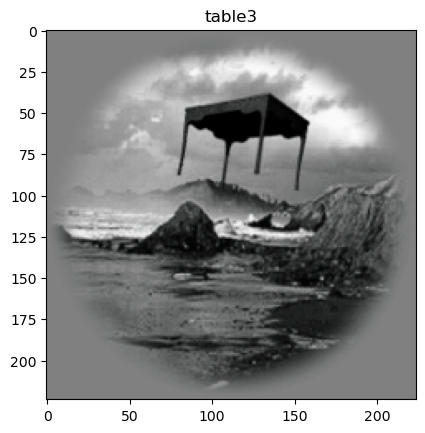

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

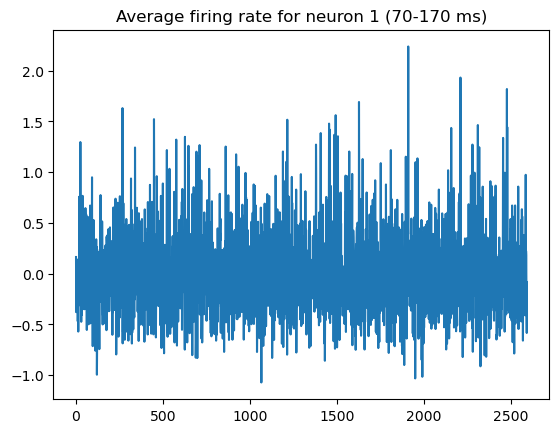

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

n_out = 168
batch_size = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if not 'cuda' in device:
    print('Using CPU')

train_dataset = TensorDataset(
    torch.from_numpy(stimulus_train).float(),
    torch.from_numpy(spikes_train).float()
)

val_dataset = TensorDataset(
    torch.from_numpy(stimulus_val).float(),
    torch.from_numpy(spikes_val).float()
)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def create_setup(optim, use_batch_norm=True):
    layers = [
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128 * (img_size // 4) * (img_size // 4), n_out)
    ]
    if use_batch_norm:
        layers.insert(2, nn.BatchNorm2d(64))
        layers.insert(6, nn.BatchNorm2d(128))

    model = nn.Sequential(*layers)
    model = model.to(device)
    print(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) if optim == 'adamw' \
        else torch.optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def do_train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        loss = 0.0
        mae = 0.0
        for data, targets in tqdm(dataloader, desc=f'Training - epoch {epoch+1}'):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)
        print('Epoch [{}/{}] MSE: {:.4f}, MAE: {:.2f}'.format(epoch+1, epochs, loss, mae))
    
def do_test(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    mae = 0.0
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc=f'Testing'):
            data, targets = data.to(device), targets.to(device)
            out = model(data)
            loss = criterion(out, targets)

            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)

    return loss, mae

In [27]:
for optim in ['adamw', 'sgd']:
    for use_batch_norm in [True, False]:
        print(f'Optimizer: {optim}, Batch Norm: {use_batch_norm}')
        model, optimizer, criterion = create_setup(optim, use_batch_norm=use_batch_norm)
        do_train(model, trainloader, optimizer, criterion, 10)
        loss, acc = do_test(model, valloader, criterion)
        print('Final MSE: {:.4f}, MAE: {:.2f}'.format(loss, acc))
        print('--' * 20)

Optimizer: adamw, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [00:15<00:00, 10.66it/s]


Epoch [1/10] MSE: 9.0649, MAE: 20.98


Training - epoch 2: 100%|██████████| 162/162 [00:14<00:00, 11.02it/s]


Epoch [2/10] MSE: 4.0193, MAE: 18.87


Training - epoch 3: 100%|██████████| 162/162 [00:15<00:00, 10.70it/s]


Epoch [3/10] MSE: 4.4337, MAE: 14.53


Training - epoch 4: 100%|██████████| 162/162 [00:15<00:00, 10.40it/s]


Epoch [4/10] MSE: 1.5193, MAE: 10.61


Training - epoch 5: 100%|██████████| 162/162 [00:15<00:00, 10.32it/s]


Epoch [5/10] MSE: 0.2225, MAE: 5.49


Training - epoch 6: 100%|██████████| 162/162 [00:15<00:00, 10.36it/s]


Epoch [6/10] MSE: 0.0017, MAE: 1.23


Training - epoch 7: 100%|██████████| 162/162 [00:15<00:00, 10.46it/s]


Epoch [7/10] MSE: 0.0015, MAE: 0.26


Training - epoch 8: 100%|██████████| 162/162 [00:15<00:00, 10.45it/s]


Epoch [8/10] MSE: 0.0012, MAE: 0.24


Training - epoch 9: 100%|██████████| 162/162 [00:15<00:00, 10.80it/s]


Epoch [9/10] MSE: 0.0013, MAE: 0.23


Training - epoch 10: 100%|██████████| 162/162 [00:15<00:00, 10.41it/s]


Epoch [10/10] MSE: 0.0010, MAE: 0.22


Testing: 100%|██████████| 18/18 [00:00<00:00, 36.66it/s]


Final MSE: 0.0113, MAE: 0.25
----------------------------------------
Optimizer: adamw, Batch Norm: False
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [00:13<00:00, 12.29it/s]


Epoch [1/10] MSE: 0.0016, MAE: 0.40


Training - epoch 2: 100%|██████████| 162/162 [00:13<00:00, 12.21it/s]


Epoch [2/10] MSE: 0.0013, MAE: 0.27


Training - epoch 3: 100%|██████████| 162/162 [00:13<00:00, 12.11it/s]


Epoch [3/10] MSE: 0.0019, MAE: 0.27


Training - epoch 4: 100%|██████████| 162/162 [00:13<00:00, 12.30it/s]


Epoch [4/10] MSE: 0.0019, MAE: 0.27


Training - epoch 5: 100%|██████████| 162/162 [00:13<00:00, 12.30it/s]


Epoch [5/10] MSE: 0.0017, MAE: 0.27


Training - epoch 6: 100%|██████████| 162/162 [00:13<00:00, 12.38it/s]


Epoch [6/10] MSE: 0.0021, MAE: 0.27


Training - epoch 7: 100%|██████████| 162/162 [00:13<00:00, 12.22it/s]


Epoch [7/10] MSE: 0.0013, MAE: 0.27


Training - epoch 8: 100%|██████████| 162/162 [00:13<00:00, 11.95it/s]


Epoch [8/10] MSE: 0.0016, MAE: 0.27


Training - epoch 9: 100%|██████████| 162/162 [00:13<00:00, 11.89it/s]


Epoch [9/10] MSE: 0.0014, MAE: 0.27


Training - epoch 10: 100%|██████████| 162/162 [00:13<00:00, 11.91it/s]


Epoch [10/10] MSE: 0.0016, MAE: 0.27


Testing: 100%|██████████| 18/18 [00:00<00:00, 44.01it/s]


Final MSE: 0.0146, MAE: 0.28
----------------------------------------
Optimizer: sgd, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [00:12<00:00, 13.41it/s]


Epoch [1/10] MSE: 0.0136, MAE: 0.84


Training - epoch 2: 100%|██████████| 162/162 [00:12<00:00, 13.32it/s]


Epoch [2/10] MSE: 0.0125, MAE: 0.81


Training - epoch 3: 100%|██████████| 162/162 [00:12<00:00, 13.30it/s]


Epoch [3/10] MSE: 0.0114, MAE: 0.79


Training - epoch 4: 100%|██████████| 162/162 [00:12<00:00, 13.34it/s]


Epoch [4/10] MSE: 0.0118, MAE: 0.78


Training - epoch 5: 100%|██████████| 162/162 [00:12<00:00, 13.39it/s]


Epoch [5/10] MSE: 0.0125, MAE: 0.77


Training - epoch 6: 100%|██████████| 162/162 [00:11<00:00, 13.56it/s]


Epoch [6/10] MSE: 0.0118, MAE: 0.76


Training - epoch 7: 100%|██████████| 162/162 [00:11<00:00, 13.62it/s]


Epoch [7/10] MSE: 0.0108, MAE: 0.75


Training - epoch 8: 100%|██████████| 162/162 [00:11<00:00, 13.64it/s]


Epoch [8/10] MSE: 0.0106, MAE: 0.74


Training - epoch 9: 100%|██████████| 162/162 [00:12<00:00, 13.45it/s]


Epoch [9/10] MSE: 0.0119, MAE: 0.74


Training - epoch 10: 100%|██████████| 162/162 [00:12<00:00, 13.31it/s]


Epoch [10/10] MSE: 0.0101, MAE: 0.73


Testing: 100%|██████████| 18/18 [00:00<00:00, 38.22it/s]


Final MSE: 0.0390, MAE: 0.46
----------------------------------------
Optimizer: sgd, Batch Norm: False
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [00:10<00:00, 15.78it/s]


Epoch [1/10] MSE: 0.0021, MAE: 0.28


Training - epoch 2: 100%|██████████| 162/162 [00:10<00:00, 15.58it/s]


Epoch [2/10] MSE: 0.0015, MAE: 0.28


Training - epoch 3: 100%|██████████| 162/162 [00:10<00:00, 16.02it/s]


Epoch [3/10] MSE: 0.0013, MAE: 0.28


Training - epoch 4: 100%|██████████| 162/162 [00:09<00:00, 16.43it/s]


Epoch [4/10] MSE: 0.0014, MAE: 0.28


Training - epoch 5: 100%|██████████| 162/162 [00:09<00:00, 16.44it/s]


Epoch [5/10] MSE: 0.0017, MAE: 0.27


Training - epoch 6: 100%|██████████| 162/162 [00:09<00:00, 16.40it/s]


Epoch [6/10] MSE: 0.0016, MAE: 0.27


Training - epoch 7: 100%|██████████| 162/162 [00:09<00:00, 16.32it/s]


Epoch [7/10] MSE: 0.0016, MAE: 0.27


Training - epoch 8: 100%|██████████| 162/162 [00:09<00:00, 16.38it/s]


Epoch [8/10] MSE: 0.0015, MAE: 0.27


Training - epoch 9: 100%|██████████| 162/162 [00:09<00:00, 16.45it/s]


Epoch [9/10] MSE: 0.0018, MAE: 0.27


Training - epoch 10: 100%|██████████| 162/162 [00:09<00:00, 16.41it/s]


Epoch [10/10] MSE: 0.0015, MAE: 0.27


Testing: 100%|██████████| 18/18 [00:00<00:00, 46.04it/s]

Final MSE: 0.0130, MAE: 0.27
----------------------------------------


Using BatchNorm for regression is a bad idea: we are predicting a continuous value, and the BatchNorm layer will normalize the output to have zero mean and unit variance. This is not what we want for regression tasks